### some preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import savgol_filter

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.titlesize'] = 16

In [2]:
zinser_fig3 = pd.read_csv('Zinser_Figure3.csv')
zinser_fig2a = pd.read_csv('Zinser_Figure2A.csv')

with nc4.Dataset('Zinser_SizeDist_logtransform-25-7.nc') as nc:
    w_obs = nc.variables['w_obs'][:]
    delta_v = 1.0/nc.variables['delta_v_inv'][:]
    v = nc.variables['v_min'][:].data * 2**(np.arange(nc.variables['m'][:])*delta_v)

pp = zinser_fig3['PP'].values
obs_time_hours = zinser_fig2a['exper time'].values

In [3]:
correct_abundance_mean = True

abundance_mean = 0.5 * (zinser_fig2a['cells A'].values + zinser_fig2a['cells B'].values)
# keep a copy of the uncorrected mean for later
abundance_mean_uncorrected = abundance_mean.copy()

print(np.log2(abundance_mean[-1]/abundance_mean[0])/2)

if correct_abundance_mean:
    for i in range(1, abundance_mean.size):
        abundance_mean[i] = max(abundance_mean[i-1], abundance_mean[i])

0.9123392903538146


### compute respiration

using the approach
$$
cellsize_{t+1} = ( cellsize_{t} + dt * (fix - loss) ) * \left(\tfrac{1}{2}\right)^{dt * divrate_t} 
$$
where $divrate_t$ is the $\log_2$ - based division rate at time $t$.

**Note 1:**

$$
\left(\tfrac{1}{2}\right)^{dt * divrate_t} 
= \left(\tfrac{1}{2}\right)^{dt * \log_2(abundance_{t+1} / abundance_t)/dt}
= \frac{abundance_{t}}{abundance_{t+1}}
$$

**Note 2:** The above approach yields nearly the same result as: 
$$
cellsize_{t+1} = cellsize_{t} * \left(\tfrac{1}{2}\right)^{dt * divrate_t} + dt * (fix - loss)  
$$
or
$$
totalC_{t+1} = totalC_{t} * dt * abundance_{t+\frac{1}{2}} * (fix - loss).
$$
See "Experiment 2" below.

In [4]:
def compute_div_log2(abundance, dt):
    return np.log2(abundance[...,1:] / abundance[...,:-1]) / dt

dt = obs_time_hours[1] - obs_time_hours[0]

# quickly verify that "2**divrate" is the same as "abundance_mean[1:]/abundance_mean[:-1]"
divrate = compute_div_log2(abundance_mean, dt) * dt
assert np.array_equiv(2**divrate, abundance_mean[1:]/abundance_mean[:-1])

#
# compute
#

# fg C cell-1
cellsize = np.sum(v[:,None] * w_obs, axis=0)
# fg C cell-1 h-1
net = (cellsize[1:]*(abundance_mean[1:]/abundance_mean[:-1]) - cellsize[:-1])/dt
loss = 0.5 * (pp[1:] + pp[:-1]) - net

obs_time_loss = 0.5 * (obs_time_hours[1:] + obs_time_hours[:-1])

### plot and assess loss

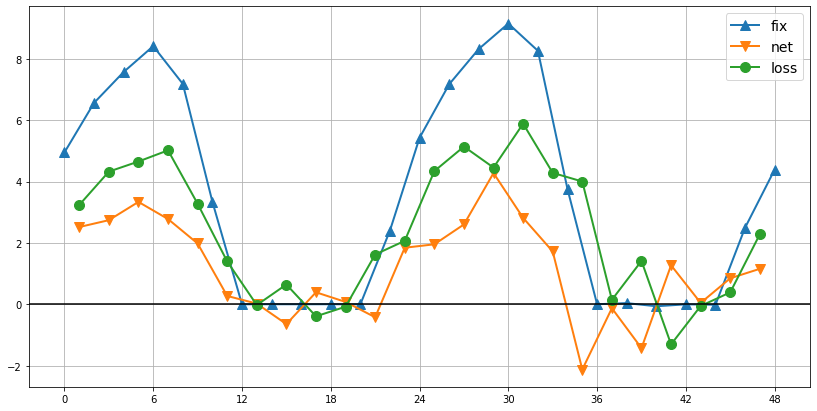

In [5]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(obs_time_hours, pp, lw=2, marker='^', label='fix', ms=10)
ax.plot(obs_time_loss, net, lw=2, marker='v', label='net', ms=10)
ax.plot(obs_time_loss, loss, lw=2, marker='o', label='loss', ms=10)
#ax.plot(obs_time_hours, cellsize*0.1, lw=2, marker='o', label='cell size/10')
#ax.plot(obs_time_loss, abundance_mean[1:]/abundance_mean[:-1], lw=2, marker='o', label='abundance ratio')
#ax.plot(obs_time_loss, (abundance_mean[1:]/abundance_mean[:-1]-1.0)*10, lw=2, marker='o', label='10 * (abundance ratio-1)')
ax.set(xticks=np.arange(0,50,6))
ax.grid(True)
ax.legend()
ax.axhline(0, color='black')
None

### a quick calculation why we would expect a carbon loss rate $L$ of somewhere close to 50 fg C cell$^{-1}$ d$^{-1}$

avg cell size at the beginning of the experiment: 40 fg C cell$^{-1}$ 

avg cell size one day later: same as above

integrated daily carbon fixation based on `pp`: 85 fg C cell$^{-1}$ d$^{-1}$

cell doubling rate (based on mean abundance): 0.9 d$^{-1}$


$$
\left(40 + 1d \; \frac{85-L}{1d} \right) \; \left(\frac{1}{2}\right)^{0.9} \approx 40 \\
40 + 85 - L \approx 75 \\
L \approx 50
$$

In [6]:
def compute_int(loss, time_hours):
    dt = np.diff(time_hours)
    return 0.5 * np.sum(dt * (loss[...,1:] + loss[...,:-1]), axis=-1) 

daily_fix = 0.5 * compute_int(pp, obs_time_hours)
daily_loss = 0.5 * compute_int(loss, obs_time_loss)

print('''avg daily carbon flux (fg C /cell /d):
     fix: {:7.3f}
    loss: {:7.3f}'''.format(
    daily_fix, daily_loss))

avg daily carbon flux (fg C /cell /d):
     fix:  84.700
    loss:  53.991


### Source of negative values

Negative values in estimated carbon losses occur when total fixed carbon (cell count $\times$ abundance) increases and there is no carbon fixation (at dark).

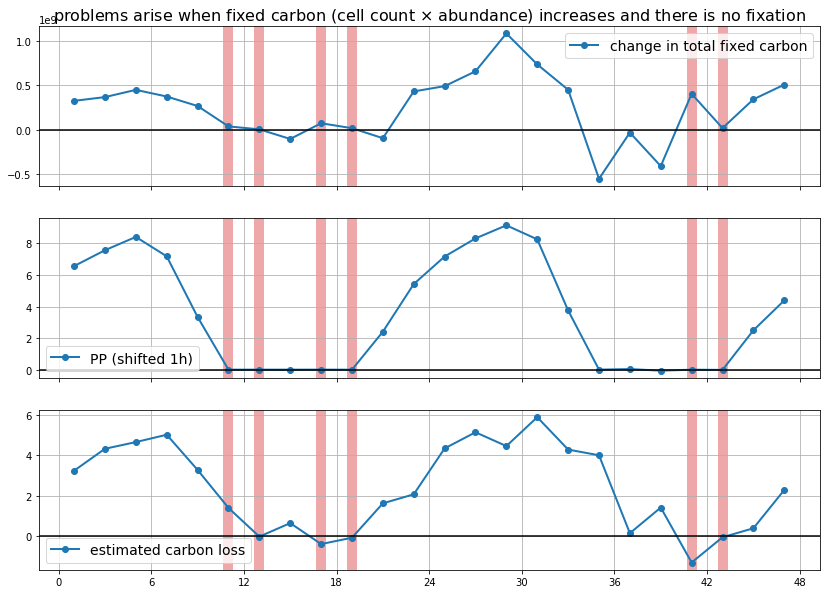

In [7]:
total_c = abundance_mean * cellsize
prop1 = total_c[1:] - total_c[:-1]

#prop2 = np.interp(obs_time_loss, xp=obs_time_hours, fp=pp)
prop2 = pp[1:]

index = np.logical_and(prop1 > 0, prop2 < 0.1)

fig, axs = plt.subplots(figsize=(14,10), nrows=3, sharex=True)
ax = axs[0]
ax.plot(obs_time_loss, prop1, lw=2, marker='o', label='change in total fixed carbon')
ax.grid(True)
ax.legend()
ax.axhline(0, color='black')
ax.set_title('problems arise when fixed carbon (cell count $\\times$ abundance) increases and there is no fixation')

ax = axs[1]
ax.plot(obs_time_loss, prop2, lw=2, marker='o', label='PP (shifted 1h)')
ax.grid(True)
ax.legend()
ax.axhline(0, color='black')

ax = axs[2]
ax.plot(obs_time_loss, loss, lw=2, marker='o', label='estimated carbon loss')
ax.set(xticks=np.arange(0,50,6))
ax.grid(True)
ax.legend()
ax.axhline(0, color='black')

for ax in axs.flat:
    for x in obs_time_loss[index]:
        ax.axvline(x, color='tab:red', lw=10, zorder=0, alpha=0.4)

None

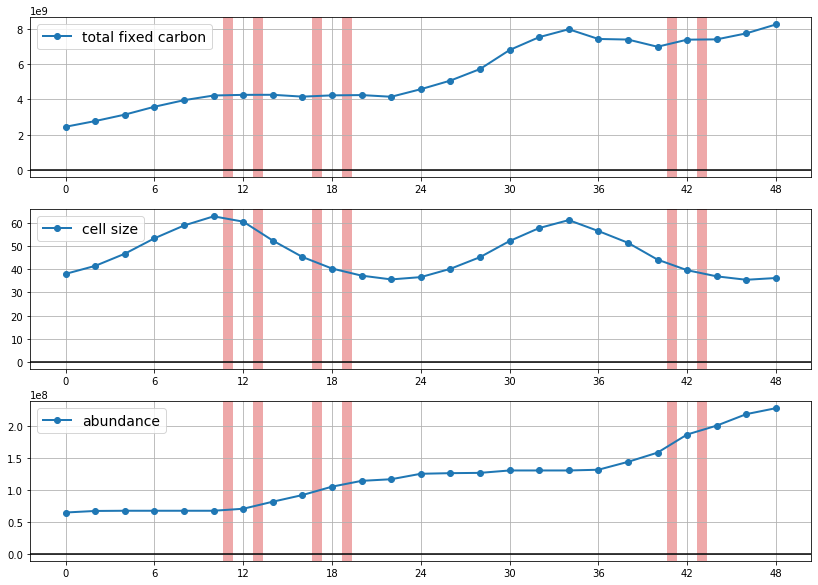

In [8]:
fig, axs = plt.subplots(figsize=(14,10), nrows=3)

ax = axs[0]
ax.plot(obs_time_hours, total_c, lw=2, marker='o', label='total fixed carbon')
ax.set(xticks=np.arange(0,50,6))
ax.grid(True)
ax.legend()
ax.axhline(0, color='black')

ax = axs[1]
ax.plot(obs_time_hours, cellsize, lw=2, marker='o', label='cell size')
ax.set(xticks=np.arange(0,50,6))
ax.grid(True)
ax.legend()
ax.axhline(0, color='black')

ax = axs[2]
ax.plot(obs_time_hours, abundance_mean, lw=2, marker='o', label='abundance')
ax.set(xticks=np.arange(0,50,6))
ax.grid(True)
ax.legend()
ax.axhline(0, color='black')

for ax in axs.flat:
    for x in obs_time_loss[index]:
        ax.axvline(x, color='tab:red', lw=10, zorder=0, alpha=0.4)

None

### Experiment 1: change resolution

In [9]:
def compute_loss(obs_time_hours, abundance, pp, w_obs, resolution=50):
    obs_time_res = np.linspace(obs_time_hours[0], obs_time_hours[-1], resolution)
    dt_res = obs_time_res[1:] - obs_time_res[:-1]
    
    w_obs_res = np.empty((w_obs.shape[0], resolution))
    for irow in range(w_obs.shape[0]):
        w_obs_res[irow,:] = np.interp(obs_time_res, xp=obs_time_hours, fp=w_obs[irow,:])
    abundance_res = np.interp(obs_time_res, xp=obs_time_hours, fp=abundance)
    pp_res = np.interp(obs_time_res, xp=obs_time_hours, fp=pp)
    
    cellsize_res = np.sum(v[:,None] * w_obs_res, axis=0)
    net_res = (cellsize_res[1:]*(abundance_res[1:]/abundance_res[:-1]) - cellsize_res[:-1]) / dt_res
    #net_res = (cellsize_res[1:] - cellsize_res[:-1]/(abundance_res[1:]/abundance_res[:-1])) / dt_res
    
    return 0.5 * (obs_time_res[1:] + obs_time_res[:-1]), pp_res[1:] - net_res

using     25 points: carbon loss  52.834 fg C /cell /d
using     51 points: carbon loss  55.208 fg C /cell /d
using    101 points: carbon loss  56.063 fg C /cell /d
using    201 points: carbon loss  56.543 fg C /cell /d


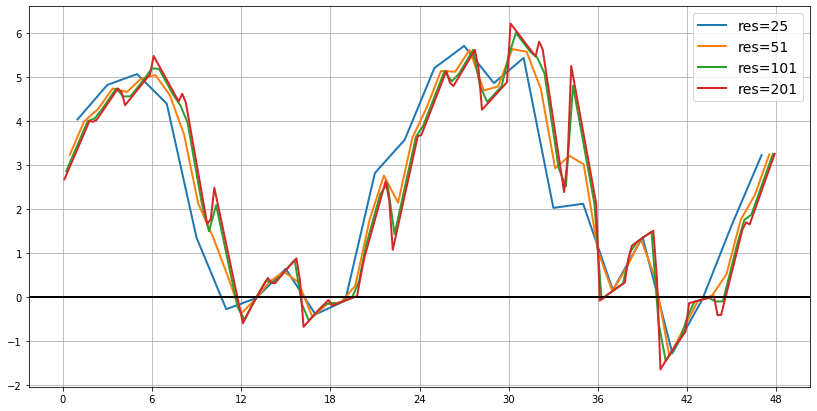

In [10]:
fig, ax = plt.subplots(figsize=(14,7))
for res in (25, 51, 101, 201):
    obs_time_loss_res, loss_res = compute_loss(obs_time_hours, abundance_mean, pp, w_obs, resolution=res)
    
    ax.plot(obs_time_loss_res, loss_res, lw=2, label='res={}'.format(res))
    ax.set(xticks=np.arange(0,50,6))
    ax.grid(True)
    ax.legend()
    ax.axhline(0, color='black')
    
    daily_loss_res = 0.5 * compute_int(loss_res, obs_time_loss_res)
    print('using {:6d} points: carbon loss {:7.3f} fg C /cell /d'.format(res, daily_loss_res))

### Experiment 2: test (slightly) different formulations

In [11]:
def compute_div_log2(abundance, dt):
    return np.log2(abundance[...,1:] / abundance[...,:-1]) / dt

losses = {}

dt = obs_time_hours[1] - obs_time_hours[0]

# fg C cell-1
cellsize = np.sum(v[:,None] * w_obs, axis=0)

divrate = compute_div_log2(abundance_mean, dt) * dt

assert np.array_equiv(2**divrate, abundance_mean[1:]/abundance_mean[:-1])

#net = (cellsize[1:]*(2**divrate) - cellsize[:-1])/dt
net = (cellsize[1:]*(abundance_mean[1:]/abundance_mean[:-1]) - cellsize[:-1])/dt
losses['abundance 1'] = pp[1:] - net

#net = (cellsize[1:] - cellsize[:-1]/(2**divrate))/dt
net = (cellsize[1:] - cellsize[:-1]/(abundance_mean[1:]/abundance_mean[:-1]))/dt
losses['abundance 2'] = pp[1:] - net

total_c = cellsize * abundance_mean
net = (total_c[1:] - total_c[:-1])/(0.5*(abundance_mean[1:] + abundance_mean[:-1]))/dt
losses['total fixed carbon'] = pp[1:] - net

obs_time_loss = 0.5 * (obs_time_hours[1:] + obs_time_hours[:-1])

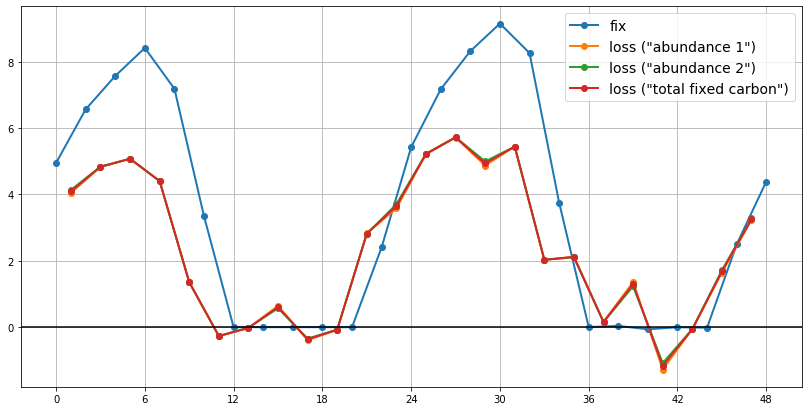

In [12]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(obs_time_hours, pp, lw=2, marker='o', label='fix')
for key in losses:
    ax.plot(obs_time_loss, losses[key], lw=2, marker='o', label='loss ("{}")'.format(key))
    
ax.set(xticks=np.arange(0,50,6))
ax.grid(True)
ax.legend()
ax.axhline(0, color='black')
None